# Initial Modeling Using XGBoost
- The goal of this notebook is to begin building models using the xgboost method

### Load necessary libraries and data

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('/data/p_dsi/teams2023/team9/')

df = pd.read_csv('Asurion_clean_data_feature_set.csv')

len(df.weeks_monday.unique())

86

## Initial train test split (grouping all data)
- For the initial modeling process, we will group all the data (ignore model group)
- We will use anything pre-2023 as the cutoff and test with all 2023 data

In [2]:
apple_g = df.groupby(['weeks_monday'], as_index = False).agg({"claim": ["sum"]})
apple_g.columns = ["date", "claims"]
print(apple_g)
print(type(apple_g))

          date  claims
0   2021-06-28    3273
1   2021-07-05    8536
2   2021-07-12    7942
3   2021-07-19    7873
4   2021-07-26    7762
..         ...     ...
81  2023-01-16   11189
82  2023-01-23   11131
83  2023-01-30    9981
84  2023-02-06   12280
85  2023-02-13    2283

[86 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [3]:
apple_g['date'] = pd.to_datetime(apple_g['date'].str[:10])
print(apple_g)
print(type(apple_g))

         date  claims
0  2021-06-28    3273
1  2021-07-05    8536
2  2021-07-12    7942
3  2021-07-19    7873
4  2021-07-26    7762
..        ...     ...
81 2023-01-16   11189
82 2023-01-23   11131
83 2023-01-30    9981
84 2023-02-06   12280
85 2023-02-13    2283

[86 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [4]:
split_date = '01-Jan-2023'
data_train = apple_g.loc[apple_g.date <= split_date].copy()
data_test = apple_g.loc[apple_g.date > split_date].copy()

print(data_train.head())
print(data_test.head())

        date  claims
0 2021-06-28    3273
1 2021-07-05    8536
2 2021-07-12    7942
3 2021-07-19    7873
4 2021-07-26    7762
         date  claims
79 2023-01-02   10908
80 2023-01-09   10608
81 2023-01-16   11189
82 2023-01-23   11131
83 2023-01-30    9981


## Creating features

In [5]:
def create_features(df, label=None):
    df['date'] = df.date
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    
    X = df[['quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [6]:
X_train, y_train = create_features(data_train, label='claims')
X_test, y_test = create_features(data_test, label='claims')
X_train

,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2,6,2021,179,28,26
1,3,7,2021,186,5,27
2,3,7,2021,193,12,28
3,3,7,2021,200,19,29
4,3,7,2021,207,26,30
...,...,...,...,...,...,...
74,4,11,2022,332,28,48
75,4,12,2022,339,5,49
76,4,12,2022,346,12,50
77,4,12,2022,353,19,51


## Model Fitting

In [7]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/connelcc/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


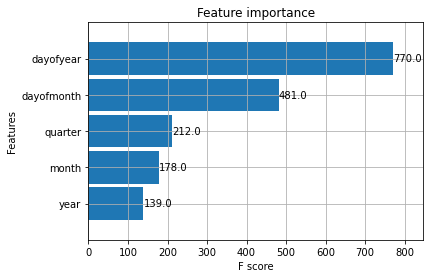

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)
_ = plot_importance(reg, height=0.9)

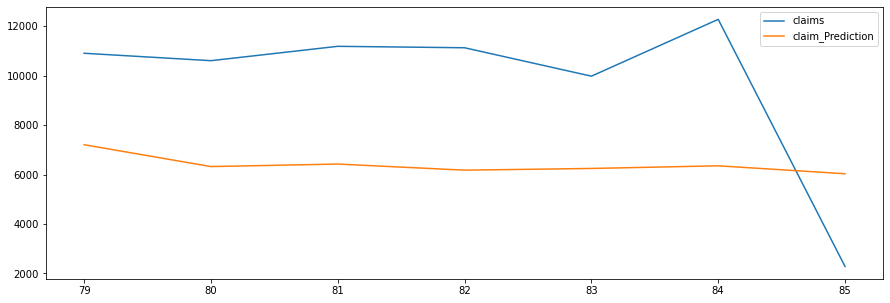

In [9]:
data_test['claim_Prediction'] = reg.predict(X_test)
_ = data_test[['claims','claim_Prediction']].plot(figsize=(15, 5))

In [10]:
score = np.sqrt(mean_squared_error(data_test['claims'], data_test['claim_Prediction']))
print(score)

4509.948049227261


### Notes
- This model is not good.
- It is off by quite a bit so it will need to be trained differently
- Gonna try not grouping it

In [11]:
apple = df
apple['weeks_monday'] = pd.to_datetime(apple['weeks_monday'].str[:10])
print(apple)
print(type(apple))

               phone model phone size phone color  claim weeks_monday  \
0          apple iphone 11      128gb       black    252   2022-01-24   
1          apple iphone 11      128gb       green     45   2022-01-24   
2          apple iphone 11      128gb      purple     92   2022-01-24   
3          apple iphone 11      128gb         red     69   2022-01-24   
4          apple iphone 11      128gb       white     91   2022-01-24   
...                    ...        ...         ...    ...          ...   
11679  apple iphone xs max      256gb      silver      4   2023-02-13   
11680  apple iphone xs max      512gb        gray      2   2023-02-13   
11681  apple iphone xs max       64gb        gold     12   2023-02-13   
11682  apple iphone xs max       64gb        gray      8   2023-02-13   
11683  apple iphone xs max       64gb      silver      1   2023-02-13   

          month  year  season quarter  Holidays_Boolean company model_group  
0       January  2022  winter      Q1        

In [12]:
split_date = '01-Jan-2023'
data_train = apple.loc[apple.weeks_monday <= split_date].copy()
data_test = apple.loc[apple.weeks_monday > split_date].copy()

print(data_train.head())
print(data_test.head())

       phone model phone size phone color  claim weeks_monday    month  year  \
0  apple iphone 11      128gb       black    252   2022-01-24  January  2022   
1  apple iphone 11      128gb       green     45   2022-01-24  January  2022   
2  apple iphone 11      128gb      purple     92   2022-01-24  January  2022   
3  apple iphone 11      128gb         red     69   2022-01-24  January  2022   
4  apple iphone 11      128gb       white     91   2022-01-24  January  2022   

   season quarter  Holidays_Boolean company model_group  
0  winter      Q1             False   apple   iphone 11  
1  winter      Q1             False   apple   iphone 11  
2  winter      Q1             False   apple   iphone 11  
3  winter      Q1             False   apple   iphone 11  
4  winter      Q1             False   apple   iphone 11  
          phone model phone size phone color  claim weeks_monday    month  \
3457  apple iphone 11      128gb       black    233   2023-01-02  January   
3458  apple iphon

In [13]:
def create_features(df, label=None):
    df['date'] = df.weeks_monday
    df['quarter'] = df['weeks_monday'].dt.quarter
    df['month'] = df['weeks_monday'].dt.month
    df['year'] = df['weeks_monday'].dt.year
    df['dayofyear'] = df['weeks_monday'].dt.dayofyear
    df['dayofmonth'] = df['weeks_monday'].dt.day
    df['weekofyear'] = df['weeks_monday'].dt.isocalendar().week.astype(int)
    
    X = df[['quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [14]:
X_train, y_train = create_features(data_train, label='claim')
X_test, y_test = create_features(data_test, label='claim')
X_train, y_train

(       quarter  month  year  dayofyear  dayofmonth  weekofyear
 0            1      1  2022         24          24           4
 1            1      1  2022         24          24           4
 2            1      1  2022         24          24           4
 3            1      1  2022         24          24           4
 4            1      1  2022         24          24           4
 ...        ...    ...   ...        ...         ...         ...
 11030        4     10  2022        297          24          43
 11031        4     10  2022        297          24          43
 11032        4     10  2022        297          24          43
 11033        4     10  2022        297          24          43
 11034        4     10  2022        297          24          43
 
 [10529 rows x 6 columns],
 0        252
 1         45
 2         92
 3         69
 4         91
         ... 
 11030     14
 11031     10
 11032     59
 11033     56
 11034     24
 Name: claim, Length: 10529, dtype: int64)

/home/connelcc/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


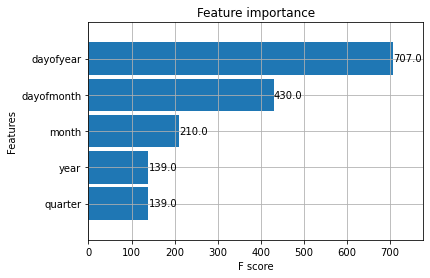

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False)
_ = plot_importance(reg, height=0.9)

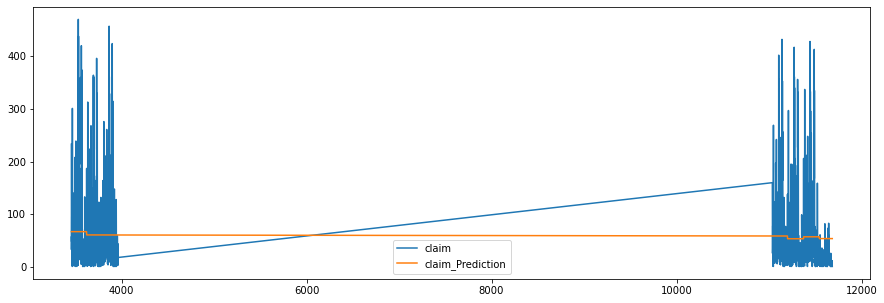

In [16]:
data_test['claim_Prediction'] = reg.predict(X_test)
_ = data_test[['claim','claim_Prediction']].plot(figsize=(15, 5))

In [17]:
score = np.sqrt(mean_squared_error(data_test['claim'], data_test['claim_Prediction']))
print(score)

80.29860132396117


## Notes
- This model also isnt great, will try some other method of xgboost
- Gonna try using rolling mean (window from 1-4) of grouped data (and maybe ungrouped if that sucks)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [19]:
split_date = '01-Jan-2023'
new_train = apple_g.loc[apple_g.date <= split_date].copy()
new_test = apple_g.loc[apple_g.date > split_date].copy()

In [20]:
def create_features(df, label=None):
    
    df['date'] = df.date
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['lag_1'] = df['claims'].shift(1)
    df['lag_2'] = df['claims'].shift(2)
    df['lag_3'] = df['claims'].shift(3)
    df['lag_4'] = df['claims'].shift(4)
    df['mean_2'] = df['claims'].rolling(window = 2).mean()
    df['mean_3'] = df['claims'].rolling(window = 3).mean()
    df['mean_4'] = df['claims'].rolling(window = 4).mean()
    
    X = df[['quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , 'lag_1' , 'lag_2' , 'lag_3',
           "lag_4" ,"mean_2" ,"mean_3" ,"mean_4"]]
    if label:
        y = df[label]
        return X, y
    return X

In [21]:
X_train, y_train = create_features(new_train, label='claims')
X_test, y_test = create_features(new_test, label='claims')

/home/connelcc/.local/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


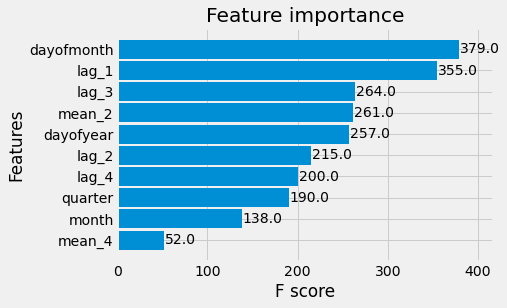

In [22]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

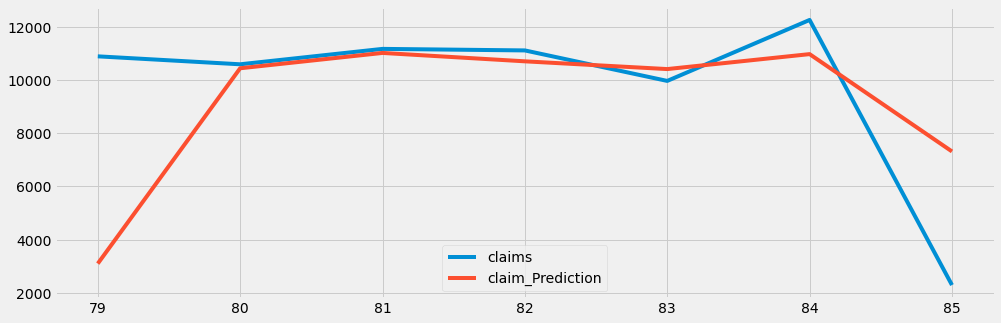

In [23]:
new_test['claim_Prediction'] = reg.predict(X_test)
plot_all = pd.concat([new_test, new_train], sort=False)

_ = new_test[['claims','claim_Prediction']].plot(figsize=(15, 5))

In [24]:
score = np.sqrt(mean_squared_error(new_test['claims'], new_test['claim_Prediction']))
print(score)

3556.725702975626


## Notes
- This performed much better, other than the first week
- Can maybe build off this

# Trying similar to model shown in class

In [25]:
# Set index, set to datetime, sort index
dat = df
dat.set_index('weeks_monday')
dat['weeks_monday'] = pd.to_datetime(dat['weeks_monday'], format='%Y-%m-%d')
dat.sort_index()
dat.head()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


In [26]:
# Transform columns into proper format
dat["color"] = dat["phone color"]
dat["model"] = dat["model_group"].str.split().str[-1]
dat['size'] = dat['phone size'].str.replace('\D', '', regex=True)

In [27]:
# Select only the relevant columns
xgbdat = dat[['color', 'claim', 'weeks_monday', 'model', 'size']]
xgbdat.head()

,color,claim,weeks_monday,model,size
0,black,252,2022-01-24,11,128
1,green,45,2022-01-24,11,128
2,purple,92,2022-01-24,11,128
3,red,69,2022-01-24,11,128
4,white,91,2022-01-24,11,128


In [28]:
# Transform columns into dummies (indicators)
xgbdat = pd.get_dummies(xgbdat, prefix=['color', 'model', 'size'])
xgbdat.head()

,claim,weeks_monday,color_black,color_blue,color_coral,color_gold,color_graphite,color_gray,color_green,color_midnight,...,model_13,model_14,model_se,model_x,size_128,size_16,size_256,size_32,size_512,size_64
0,252,2022-01-24,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,45,2022-01-24,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,92,2022-01-24,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,69,2022-01-24,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,91,2022-01-24,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [29]:
# Creating features off date
xgbdat['quarter'] = xgbdat['weeks_monday'].dt.quarter
xgbdat['month'] = xgbdat['weeks_monday'].dt.month
xgbdat['year'] = xgbdat['weeks_monday'].dt.year
xgbdat['dayofyear'] = xgbdat['weeks_monday'].dt.dayofyear
xgbdat['dayofmonth'] = xgbdat['weeks_monday'].dt.day
xgbdat['weekofyear'] = xgbdat['weeks_monday'].dt.isocalendar().week.astype(int)
xgbdat['lag'] = xgbdat['claim'].shift(1)

In [30]:
# Train test split
split_ratio = 0.75

train = xgbdat.iloc[:int(len(xgbdat)*split_ratio)]
test = xgbdat.iloc[int(len(xgbdat)*split_ratio):]

features = xgbdat.columns.to_list()
features.remove('claim')
features.remove('weeks_monday')
target = 'claim'



xtrain = train[features]
ytrain = train[target]

xtest = test[features]
ytest = test[target]

In [31]:
# Build model
mod = xgb.XGBRegressor(base_score = 0.2, booster = 'gbtree', n_estimators = 1000,
                       objective = 'reg:linear', max_depth = 5, learning_rate = 0.01)

mod.fit(xtrain, ytrain, eval_set = [(xtrain, ytrain), (xtest, ytest)])

[14:20:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:99.99245	validation_1-rmse:89.68068
[1]	validation_0-rmse:99.26277	validation_1-rmse:89.01288
[2]	validation_0-rmse:98.54216	validation_1-rmse:88.35646
[3]	validation_0-rmse:97.83028	validation_1-rmse:87.70611
[4]	validation_0-rmse:97.12463	validation_1-rmse:87.06396
[5]	validation_0-rmse:96.43070	validation_1-rmse:86.43463
[6]	validation_0-rmse:95.74499	validation_1-rmse:85.80992
[7]	validation_0-rmse:95.06518	validation_1-rmse:85.19370
[8]	validation_0-rmse:94.39904	validation_1-rmse:84.58845
[9]	validation_0-rmse:93.73622	validation_1-rmse:83.99089
[10]	validation_0-rmse:93.08420	validation_1-rmse:83.39907
[11]	validation_0-rmse:92.43815	validation_1-rmse:82.81732
[12]	validation_0-rmse:91.80231	validation_1-rmse:82.24436
[13]	validation_0-rmse:91.17468	validation_1-rmse:81.67645
[14]	validation_0-rmse:90.55264	validation_1-rmse:81.11861
[15]	v

[137]	validation_0-rmse:53.12276	validation_1-rmse:49.91028
[138]	validation_0-rmse:53.00945	validation_1-rmse:49.82448
[139]	validation_0-rmse:52.88477	validation_1-rmse:49.73028
[140]	validation_0-rmse:52.76548	validation_1-rmse:49.64518
[141]	validation_0-rmse:52.66523	validation_1-rmse:49.57432
[142]	validation_0-rmse:52.54266	validation_1-rmse:49.49626
[143]	validation_0-rmse:52.45305	validation_1-rmse:49.43131
[144]	validation_0-rmse:52.29580	validation_1-rmse:49.30370
[145]	validation_0-rmse:52.18230	validation_1-rmse:49.22719
[146]	validation_0-rmse:52.05536	validation_1-rmse:49.14714
[147]	validation_0-rmse:51.93962	validation_1-rmse:49.07455
[148]	validation_0-rmse:51.85571	validation_1-rmse:49.01474
[149]	validation_0-rmse:51.70588	validation_1-rmse:48.89163
[150]	validation_0-rmse:51.59361	validation_1-rmse:48.81301
[151]	validation_0-rmse:51.51316	validation_1-rmse:48.75626
[152]	validation_0-rmse:51.41122	validation_1-rmse:48.68322
[153]	validation_0-rmse:51.30600	validat

[274]	validation_0-rmse:44.57316	validation_1-rmse:43.99423
[275]	validation_0-rmse:44.55500	validation_1-rmse:43.98302
[276]	validation_0-rmse:44.53283	validation_1-rmse:43.96527
[277]	validation_0-rmse:44.49501	validation_1-rmse:43.93872
[278]	validation_0-rmse:44.47748	validation_1-rmse:43.93344
[279]	validation_0-rmse:44.44192	validation_1-rmse:43.90496
[280]	validation_0-rmse:44.42376	validation_1-rmse:43.89330
[281]	validation_0-rmse:44.38894	validation_1-rmse:43.86540
[282]	validation_0-rmse:44.36781	validation_1-rmse:43.84822
[283]	validation_0-rmse:44.33241	validation_1-rmse:43.82261
[284]	validation_0-rmse:44.30015	validation_1-rmse:43.80231
[285]	validation_0-rmse:44.26030	validation_1-rmse:43.77399
[286]	validation_0-rmse:44.22632	validation_1-rmse:43.75009
[287]	validation_0-rmse:44.18617	validation_1-rmse:43.72232
[288]	validation_0-rmse:44.16211	validation_1-rmse:43.70577
[289]	validation_0-rmse:44.12965	validation_1-rmse:43.67940
[290]	validation_0-rmse:44.10491	validat

[411]	validation_0-rmse:41.86781	validation_1-rmse:42.21913
[412]	validation_0-rmse:41.85867	validation_1-rmse:42.21319
[413]	validation_0-rmse:41.84704	validation_1-rmse:42.20467
[414]	validation_0-rmse:41.83970	validation_1-rmse:42.19810
[415]	validation_0-rmse:41.83239	validation_1-rmse:42.19407
[416]	validation_0-rmse:41.81892	validation_1-rmse:42.18827
[417]	validation_0-rmse:41.81266	validation_1-rmse:42.18431
[418]	validation_0-rmse:41.79941	validation_1-rmse:42.17771
[419]	validation_0-rmse:41.79327	validation_1-rmse:42.17392
[420]	validation_0-rmse:41.78589	validation_1-rmse:42.16891
[421]	validation_0-rmse:41.77467	validation_1-rmse:42.16098
[422]	validation_0-rmse:41.76470	validation_1-rmse:42.15503
[423]	validation_0-rmse:41.75706	validation_1-rmse:42.14942
[424]	validation_0-rmse:41.74414	validation_1-rmse:42.14409
[425]	validation_0-rmse:41.73838	validation_1-rmse:42.14032
[426]	validation_0-rmse:41.72348	validation_1-rmse:42.13504
[427]	validation_0-rmse:41.70551	validat

[548]	validation_0-rmse:40.55489	validation_1-rmse:41.49653
[549]	validation_0-rmse:40.54456	validation_1-rmse:41.49249
[550]	validation_0-rmse:40.53079	validation_1-rmse:41.48424
[551]	validation_0-rmse:40.51986	validation_1-rmse:41.47621
[552]	validation_0-rmse:40.51419	validation_1-rmse:41.47273
[553]	validation_0-rmse:40.50112	validation_1-rmse:41.46823
[554]	validation_0-rmse:40.49422	validation_1-rmse:41.46620
[555]	validation_0-rmse:40.48441	validation_1-rmse:41.46003
[556]	validation_0-rmse:40.47891	validation_1-rmse:41.45605
[557]	validation_0-rmse:40.47219	validation_1-rmse:41.45379
[558]	validation_0-rmse:40.46176	validation_1-rmse:41.44599
[559]	validation_0-rmse:40.45629	validation_1-rmse:41.44268
[560]	validation_0-rmse:40.44290	validation_1-rmse:41.44591
[561]	validation_0-rmse:40.43919	validation_1-rmse:41.44401
[562]	validation_0-rmse:40.42919	validation_1-rmse:41.44075
[563]	validation_0-rmse:40.41604	validation_1-rmse:41.43266
[564]	validation_0-rmse:40.40332	validat

[685]	validation_0-rmse:39.52942	validation_1-rmse:41.01926
[686]	validation_0-rmse:39.52480	validation_1-rmse:41.02178
[687]	validation_0-rmse:39.51994	validation_1-rmse:41.01665
[688]	validation_0-rmse:39.51744	validation_1-rmse:41.01556
[689]	validation_0-rmse:39.51206	validation_1-rmse:41.01584
[690]	validation_0-rmse:39.50370	validation_1-rmse:41.00743
[691]	validation_0-rmse:39.49394	validation_1-rmse:41.00581
[692]	validation_0-rmse:39.49142	validation_1-rmse:41.00476
[693]	validation_0-rmse:39.48370	validation_1-rmse:41.00460
[694]	validation_0-rmse:39.47880	validation_1-rmse:40.99926
[695]	validation_0-rmse:39.47304	validation_1-rmse:40.99618
[696]	validation_0-rmse:39.46785	validation_1-rmse:40.99662
[697]	validation_0-rmse:39.45982	validation_1-rmse:40.98937
[698]	validation_0-rmse:39.44282	validation_1-rmse:40.98664
[699]	validation_0-rmse:39.44085	validation_1-rmse:40.98535
[700]	validation_0-rmse:39.43286	validation_1-rmse:40.97713
[701]	validation_0-rmse:39.43066	validat

[822]	validation_0-rmse:38.56807	validation_1-rmse:40.63888
[823]	validation_0-rmse:38.56263	validation_1-rmse:40.63418
[824]	validation_0-rmse:38.55005	validation_1-rmse:40.63244
[825]	validation_0-rmse:38.54596	validation_1-rmse:40.63043
[826]	validation_0-rmse:38.53938	validation_1-rmse:40.62706
[827]	validation_0-rmse:38.53473	validation_1-rmse:40.62677
[828]	validation_0-rmse:38.53141	validation_1-rmse:40.62546
[829]	validation_0-rmse:38.52723	validation_1-rmse:40.62306
[830]	validation_0-rmse:38.52379	validation_1-rmse:40.62182
[831]	validation_0-rmse:38.51567	validation_1-rmse:40.61707
[832]	validation_0-rmse:38.51169	validation_1-rmse:40.61379
[833]	validation_0-rmse:38.50508	validation_1-rmse:40.61588
[834]	validation_0-rmse:38.49818	validation_1-rmse:40.61131
[835]	validation_0-rmse:38.49295	validation_1-rmse:40.60731
[836]	validation_0-rmse:38.48881	validation_1-rmse:40.60492
[837]	validation_0-rmse:38.48499	validation_1-rmse:40.60204
[838]	validation_0-rmse:38.47858	validat

[959]	validation_0-rmse:37.90750	validation_1-rmse:40.39338
[960]	validation_0-rmse:37.90517	validation_1-rmse:40.39117
[961]	validation_0-rmse:37.90174	validation_1-rmse:40.39056
[962]	validation_0-rmse:37.89001	validation_1-rmse:40.38288
[963]	validation_0-rmse:37.88575	validation_1-rmse:40.38089
[964]	validation_0-rmse:37.88345	validation_1-rmse:40.37871
[965]	validation_0-rmse:37.88250	validation_1-rmse:40.37834
[966]	validation_0-rmse:37.87881	validation_1-rmse:40.37713
[967]	validation_0-rmse:37.87349	validation_1-rmse:40.38312
[968]	validation_0-rmse:37.86757	validation_1-rmse:40.37774
[969]	validation_0-rmse:37.86665	validation_1-rmse:40.37744
[970]	validation_0-rmse:37.86572	validation_1-rmse:40.37697
[971]	validation_0-rmse:37.86192	validation_1-rmse:40.37325
[972]	validation_0-rmse:37.86013	validation_1-rmse:40.37991
[973]	validation_0-rmse:37.85863	validation_1-rmse:40.38028
[974]	validation_0-rmse:37.85049	validation_1-rmse:40.37760
[975]	validation_0-rmse:37.84874	validat

XGBRegressor(base_score=0.2, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [33]:
# Score model
test['claim_pred'] = mod.predict(xtest)
score = np.sqrt(mean_squared_error(test['claim'], test['claim_pred']))
print(score)

40.32421558369486


/tmp/ipykernel_171038/1934384479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['claim_pred'] = mod.predict(xtest)


In [35]:
calc_wmape(test['claim'], test['claim_pred'])

40.69828798029511

## Hyper Parameter Tuning

In [195]:
dtrain = xgb.DMatrix(xtrain, label=ytrain)
dtest = xgb.DMatrix(xtest, label=ytest)

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

params['eval_metric'] = "rmse"

num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

In [197]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,80.654056,0.939578,82.301426,4.066592
1,64.918408,1.001043,68.292904,5.309258
2,54.622508,1.237656,59.780006,5.424035
3,47.896835,1.276092,54.776682,6.192172
4,43.311242,1.602498,52.295091,6.814672
5,40.318634,1.670009,51.127912,6.899053
6,37.880448,1.761403,50.377761,7.093206
7,36.117605,1.966137,50.054338,6.886224
8,34.983168,2.068611,49.918248,7.042672
9,33.699529,2.138898,49.835307,7.163701


In [198]:
cv_results['test-rmse-mean'].min()

49.835306657498926

In [199]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	RMSE 51.27577973651347 for 6 rounds
CV with max_depth=9, min_child_weight=6
	RMSE 50.76643339425668 for 7 rounds
CV with max_depth=9, min_child_weight=7
	RMSE 50.455582400795414 for 7 rounds
CV with max_depth=10, min_child_weight=5
	RMSE 51.12752882022373 for 7 rounds
CV with max_depth=10, min_child_weight=6
	RMSE 50.60840824731967 for 8 rounds
CV with max_depth=10, min_child_weight=7
	RMSE 50.83903741693531 for 10 rounds
CV with max_depth=11, min_child_weight=5
	RMSE 51.10770532980844 for 7 rounds
CV with max_depth=11, min_child_weight=6
	RMSE 50.617671108402256 for 7 rounds
CV with max_depth=11, min_child_weight=7
	RMSE 50.400393721910454 for 7 rounds
Best params: 11, 7, RMSE: 50.400393721910454


In [200]:
params['max_depth'] = 11
params['min_child_weight'] = 7

In [201]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 50.400393721910454 for 7 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 49.98574029181472 for 8 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 50.4860144155319 for 7 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 50.68255437952858 for 10 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 50.45308317403514 for 7 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 50.37526038474879 for 8 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 50.49374146661886 for 9 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 51.97774683034329 for 7 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 50.09780568853938 for 8 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 50.2084229833799 for 9 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 50.76744560034746 for 8 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 51.28204448838697 for 10 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 49.782299269044366 for 7 rounds
CV with subsample=0.7, colsample=0.9

In [202]:
params['subsample'] = 0.7
params['colsample_bytree'] = 1.0

In [203]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
CV with eta=0.3
CPU times: user 1.93 s, sys: 37.1 ms, total: 1.97 s
Wall time: 284 ms
	RMSE 49.782299269044366 for 7 rounds

CV with eta=0.2
CPU times: user 2.39 s, sys: 60 ms, total: 2.45 s
Wall time: 350 ms
	RMSE 49.07869624455272 for 11 rounds

CV with eta=0.1
CPU times: user 4.47 s, sys: 127 ms, total: 4.59 s
Wall time: 656 ms
	RMSE 49.149499181886924 for 25 rounds

CV with eta=0.05
CPU times: user 9.53 s, sys: 252 ms, total: 9.78 s
Wall time: 1.4 s
	RMSE 48.772205962151034 for 61 rounds

CV with eta=0.01
CPU times: user 35.1 s, sys: 863 ms, total: 36 s
Wall time: 5.14 s
	RMSE 48.918384158280304 for 279 rounds

CV with eta=0.005
CPU times: user 1min 13s, sys: 1.81 s, total: 1min 15s
Wall time: 10.8 s
	RMSE 49.01297545861052 for 583 rounds

Best params: 0.05, RMSE: 48.772205962151034


In [204]:
params['eta'] = .05

In [205]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-rmse:101.26223
[1]	Test-rmse:97.47851
[2]	Test-rmse:93.82393
[3]	Test-rmse:90.48366
[4]	Test-rmse:87.05559
[5]	Test-rmse:84.08480
[6]	Test-rmse:81.22342
[7]	Test-rmse:78.47174
[8]	Test-rmse:76.16202
[9]	Test-rmse:73.85857
[10]	Test-rmse:71.90361
[11]	Test-rmse:69.97748
[12]	Test-rmse:68.22830
[13]	Test-rmse:66.45539
[14]	Test-rmse:64.91798
[15]	Test-rmse:63.44304
[16]	Test-rmse:62.07928
[17]	Test-rmse:60.82336
[18]	Test-rmse:59.49491
[19]	Test-rmse:58.44517
[20]	Test-rmse:57.28550
[21]	Test-rmse:56.24537
[22]	Test-rmse:55.29420
[23]	Test-rmse:54.61855
[24]	Test-rmse:53.81787
[25]	Test-rmse:53.02640
[26]	Test-rmse:52.52566
[27]	Test-rmse:52.09220
[28]	Test-rmse:51.49633
[29]	Test-rmse:50.92702
[30]	Test-rmse:50.56585
[31]	Test-rmse:50.08805
[32]	Test-rmse:49.75304
[33]	Test-rmse:49.45815
[34]	Test-rmse:49.26616
[35]	Test-rmse:48.98532
[36]	Test-rmse:48.68021
[37]	Test-rmse:48.45609
[38]	Test-rmse:48.33338
[39]	Test-rmse:48.04459
[40]	Test-rmse:47.87361
[41]	Test-rmse:47.73455
[

In [209]:
test['claim_pred'] = model.predict(dtest)
calc_wmape(test['claim'], test['claim_pred'])

/tmp/ipykernel_55533/3024157053.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['claim_pred'] = model.predict(dtest)


37.657546529172286

## Try another method

In [44]:
from sklearn.model_selection import GridSearchCV

model = xgb.XGBRegressor(random_state = 42)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [50, 100, 200]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(xtrain, ytrain)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best score:  0.7443652939482399


## Next Model Ideas
- Use just iPhone 13 data, it seems that it will be the most similar
- Include 'days since release' variable
- Score with WMAPE not RMSE

In [34]:
### WMAPE Formula
def calc_wmape(actual, pred):

    abs_diff = abs(actual - pred)
    weight = (abs_diff / actual * 100) * actual
    total_weight = weight.sum()
    total_claims = actual.sum()
    
    return (total_weight/total_claims)

In [46]:
calc_wmape(test['claim'], test['claim_pred'])

40.69828798029511

In [186]:
df['weeks_monday'] = pd.to_datetime(df['weeks_monday'], format='%Y-%m-%d')

iphone13 = df[df["model_group"] == "iphone 13"]
iphone14 = df[df["model_group"] == "iphone 14"]
print(iphone13.shape); print(iphone14.shape)

(1661, 15)
(68, 15)


In [187]:
from datetime import datetime

iphone13 = iphone13.assign(since_release = lambda x: (x.weeks_monday - datetime.strptime("2021-09-24", '%Y-%m-%d')))
iphone14 = iphone14.assign(since_release = lambda x: (x.weeks_monday - datetime.strptime("2022-09-16", '%Y-%m-%d')))

In [188]:
iphone13["since_release"] = iphone13["since_release"].astype(str)
iphone13["since_release"] = iphone13["since_release"].str.split().str[0].astype(int)
iphone14["since_release"] = iphone14["since_release"].astype(str)
iphone14["since_release"] = iphone14["since_release"].str.split().str[0].astype(int)
print(iphone13.shape); print(iphone14.shape)

(1661, 16)
(68, 16)


In [189]:
iphone13 = iphone13[iphone13["weeks_monday"] != "2023-02-06"]
iphone13 = iphone13[iphone13["weeks_monday"] != "2023-02-06"]
iphone14 = iphone14[iphone14["weeks_monday"] != "2023-02-06"]
iphone14 = iphone14[iphone14["weeks_monday"] != "2023-02-06"]
print(iphone13.shape); print(iphone14.shape)

(1620, 16)
(58, 16)


## Train based on iPhone 13

In [190]:
# Set index, set to datetime, sort index
dat = iphone13
dat.set_index('weeks_monday')
dat['weeks_monday'] = pd.to_datetime(dat['weeks_monday'], format='%Y-%m-%d')
dat.sort_index()

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group,color,model,size,since_release
63,apple iphone 13,128gb,midnight,11,2022-01-24,January,2022,winter,Q1,False,apple,iphone 13,midnight,13,128,122
189,apple iphone 13,128gb,blue,144,2022-11-14,November,2022,autumn,Q4,False,apple,iphone 13,blue,13,128,416
190,apple iphone 13,128gb,green,13,2022-11-14,November,2022,autumn,Q4,False,apple,iphone 13,green,13,128,416
191,apple iphone 13,128gb,midnight,74,2022-11-14,November,2022,autumn,Q4,False,apple,iphone 13,midnight,13,128,416
192,apple iphone 13,128gb,pink,128,2022-11-14,November,2022,autumn,Q4,False,apple,iphone 13,pink,13,128,416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11646,apple iphone 13 pro max,256gb,graphite,60,2023-02-13,February,2023,winter,Q1,False,apple,iphone 13,graphite,13,256,507
11647,apple iphone 13 pro max,256gb,green,12,2023-02-13,February,2023,winter,Q1,False,apple,iphone 13,green,13,256,507
11648,apple iphone 13 pro max,256gb,silver,16,2023-02-13,February,2023,winter,Q1,False,apple,iphone 13,silver,13,256,507
11649,apple iphone 13 pro max,512gb,blue,15,2023-02-13,February,2023,winter,Q1,False,apple,iphone 13,blue,13,512,507


In [191]:
xgbdat = dat[['color', 'claim', 'weeks_monday', 'model', 'size', 'since_release']]

In [192]:
xgbdat = pd.get_dummies(xgbdat, prefix=['color', 'model', 'size'])

In [182]:
xgbdat.head()

,claim,weeks_monday,since_release,color_blue,color_gold,color_graphite,color_green,color_midnight,color_pink,color_red,color_silver,color_starlight,model_13,size_128,size_256,size_512
63,11,2022-01-24,122,0,0,0,0,1,0,0,0,0,1,1,0,0
189,144,2022-11-14,416,1,0,0,0,0,0,0,0,0,1,1,0,0
190,13,2022-11-14,416,0,0,0,1,0,0,0,0,0,1,1,0,0
191,74,2022-11-14,416,0,0,0,0,1,0,0,0,0,1,1,0,0
192,128,2022-11-14,416,0,0,0,0,0,1,0,0,0,1,1,0,0


In [193]:
xgbdat['quarter'] = xgbdat['weeks_monday'].dt.quarter
xgbdat['month'] = xgbdat['weeks_monday'].dt.month
xgbdat['year'] = xgbdat['weeks_monday'].dt.year
xgbdat['dayofyear'] = xgbdat['weeks_monday'].dt.dayofyear
xgbdat['dayofmonth'] = xgbdat['weeks_monday'].dt.day
xgbdat['weekofyear'] = xgbdat['weeks_monday'].dt.isocalendar().week.astype(int)
xgbdat['lag'] = xgbdat['claim'].shift(1)

In [194]:
# Train test split
split_ratio = 0.75

train = xgbdat.iloc[:int(len(xgbdat)*split_ratio)]
test = xgbdat.iloc[int(len(xgbdat)*split_ratio):]

features = xgbdat.columns.to_list()
features.remove('claim')
features.remove('weeks_monday')
target = 'claim'

xtrain = train[features]
ytrain = train[target]

xtest = test[features]
ytest = test[target]

In [185]:
# Build model
mod = xgb.XGBRegressor(base_score = 0.2, booster = 'gbtree', n_estimators = 1000,
                       objective = 'reg:linear', max_depth = 5, learning_rate = 0.01)
mod.fit(xtrain, ytrain, eval_set = [(xtrain, ytrain), (xtest, ytest)])

[12:50:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:103.65204	validation_1-rmse:104.84029
[1]	validation_0-rmse:102.86037	validation_1-rmse:104.06748
[2]	validation_0-rmse:102.07790	validation_1-rmse:103.30270
[3]	validation_0-rmse:101.30474	validation_1-rmse:102.54874
[4]	validation_0-rmse:100.53952	validation_1-rmse:101.79393
[5]	validation_0-rmse:99.78435	validation_1-rmse:101.05717
[6]	validation_0-rmse:99.03720	validation_1-rmse:100.32233
[7]	validation_0-rmse:98.29978	validation_1-rmse:99.60362
[8]	validation_0-rmse:97.57039	validation_1-rmse:98.88960
[9]	validation_0-rmse:96.84963	validation_1-rmse:98.18200
[10]	validation_0-rmse:96.13973	validation_1-rmse:97.49290
[11]	validation_0-rmse:95.43617	validation_1-rmse:96.80561
[12]	validation_0-rmse:94.74290	validation_1-rmse:96.13208
[13]	validation_0-rmse:94.05571	validation_1-rmse:95.45909
[14]	validation_0-rmse:93.37751	validation_1-rmse:94.

[137]	validation_0-rmse:51.19310	validation_1-rmse:55.89755
[138]	validation_0-rmse:51.04641	validation_1-rmse:55.76918
[139]	validation_0-rmse:50.90866	validation_1-rmse:55.65063
[140]	validation_0-rmse:50.76590	validation_1-rmse:55.52635
[141]	validation_0-rmse:50.60507	validation_1-rmse:55.37872
[142]	validation_0-rmse:50.48167	validation_1-rmse:55.27108
[143]	validation_0-rmse:50.33976	validation_1-rmse:55.14708
[144]	validation_0-rmse:50.21029	validation_1-rmse:55.03745
[145]	validation_0-rmse:50.07668	validation_1-rmse:54.92570
[146]	validation_0-rmse:49.95991	validation_1-rmse:54.82531
[147]	validation_0-rmse:49.80474	validation_1-rmse:54.67989
[148]	validation_0-rmse:49.67733	validation_1-rmse:54.56118
[149]	validation_0-rmse:49.55198	validation_1-rmse:54.45499
[150]	validation_0-rmse:49.43477	validation_1-rmse:54.35032
[151]	validation_0-rmse:49.31320	validation_1-rmse:54.24823
[152]	validation_0-rmse:49.19069	validation_1-rmse:54.14564
[153]	validation_0-rmse:49.08384	validat

[274]	validation_0-rmse:41.71861	validation_1-rmse:48.83763
[275]	validation_0-rmse:41.68840	validation_1-rmse:48.82384
[276]	validation_0-rmse:41.65167	validation_1-rmse:48.81612
[277]	validation_0-rmse:41.62508	validation_1-rmse:48.79725
[278]	validation_0-rmse:41.60034	validation_1-rmse:48.78144
[279]	validation_0-rmse:41.56315	validation_1-rmse:48.77755
[280]	validation_0-rmse:41.53773	validation_1-rmse:48.76180
[281]	validation_0-rmse:41.51379	validation_1-rmse:48.74429
[282]	validation_0-rmse:41.49319	validation_1-rmse:48.72788
[283]	validation_0-rmse:41.46982	validation_1-rmse:48.71324
[284]	validation_0-rmse:41.44842	validation_1-rmse:48.70105
[285]	validation_0-rmse:41.42562	validation_1-rmse:48.68688
[286]	validation_0-rmse:41.40373	validation_1-rmse:48.67591
[287]	validation_0-rmse:41.37412	validation_1-rmse:48.66635
[288]	validation_0-rmse:41.34030	validation_1-rmse:48.66115
[289]	validation_0-rmse:41.31843	validation_1-rmse:48.64548
[290]	validation_0-rmse:41.28406	validat

[411]	validation_0-rmse:38.98606	validation_1-rmse:48.36365
[412]	validation_0-rmse:38.96943	validation_1-rmse:48.35624
[413]	validation_0-rmse:38.96448	validation_1-rmse:48.35293
[414]	validation_0-rmse:38.94837	validation_1-rmse:48.35067
[415]	validation_0-rmse:38.94039	validation_1-rmse:48.35285
[416]	validation_0-rmse:38.91402	validation_1-rmse:48.37977
[417]	validation_0-rmse:38.89801	validation_1-rmse:48.37780
[418]	validation_0-rmse:38.89025	validation_1-rmse:48.38023
[419]	validation_0-rmse:38.86427	validation_1-rmse:48.40760
[420]	validation_0-rmse:38.84944	validation_1-rmse:48.41194
[421]	validation_0-rmse:38.84477	validation_1-rmse:48.40923
[422]	validation_0-rmse:38.82915	validation_1-rmse:48.40539
[423]	validation_0-rmse:38.82458	validation_1-rmse:48.40195
[424]	validation_0-rmse:38.81325	validation_1-rmse:48.40445
[425]	validation_0-rmse:38.80290	validation_1-rmse:48.40846
[426]	validation_0-rmse:38.78148	validation_1-rmse:48.43065
[427]	validation_0-rmse:38.75603	validat

[548]	validation_0-rmse:36.52688	validation_1-rmse:48.62296
[549]	validation_0-rmse:36.52209	validation_1-rmse:48.62259
[550]	validation_0-rmse:36.51080	validation_1-rmse:48.62585
[551]	validation_0-rmse:36.50612	validation_1-rmse:48.62550
[552]	validation_0-rmse:36.47988	validation_1-rmse:48.61271
[553]	validation_0-rmse:36.46537	validation_1-rmse:48.60193
[554]	validation_0-rmse:36.45891	validation_1-rmse:48.59724
[555]	validation_0-rmse:36.45432	validation_1-rmse:48.59688
[556]	validation_0-rmse:36.44328	validation_1-rmse:48.59867
[557]	validation_0-rmse:36.43605	validation_1-rmse:48.59991
[558]	validation_0-rmse:36.42521	validation_1-rmse:48.60174
[559]	validation_0-rmse:36.42073	validation_1-rmse:48.60144
[560]	validation_0-rmse:36.41201	validation_1-rmse:48.60053
[561]	validation_0-rmse:36.40138	validation_1-rmse:48.60384
[562]	validation_0-rmse:36.39700	validation_1-rmse:48.60356
[563]	validation_0-rmse:36.39005	validation_1-rmse:48.60437
[564]	validation_0-rmse:36.37882	validat

[685]	validation_0-rmse:35.11373	validation_1-rmse:48.52190
[686]	validation_0-rmse:35.11195	validation_1-rmse:48.52280
[687]	validation_0-rmse:35.07943	validation_1-rmse:48.52005
[688]	validation_0-rmse:35.07466	validation_1-rmse:48.51918
[689]	validation_0-rmse:35.06669	validation_1-rmse:48.51788
[690]	validation_0-rmse:35.05072	validation_1-rmse:48.51750
[691]	validation_0-rmse:35.03164	validation_1-rmse:48.50854
[692]	validation_0-rmse:34.99959	validation_1-rmse:48.51133
[693]	validation_0-rmse:34.99755	validation_1-rmse:48.51215
[694]	validation_0-rmse:34.96564	validation_1-rmse:48.51463
[695]	validation_0-rmse:34.96102	validation_1-rmse:48.51267
[696]	validation_0-rmse:34.94570	validation_1-rmse:48.51255
[697]	validation_0-rmse:34.93295	validation_1-rmse:48.50522
[698]	validation_0-rmse:34.92621	validation_1-rmse:48.50632
[699]	validation_0-rmse:34.92342	validation_1-rmse:48.50782
[700]	validation_0-rmse:34.91393	validation_1-rmse:48.50228
[701]	validation_0-rmse:34.90399	validat

[822]	validation_0-rmse:33.47389	validation_1-rmse:48.58771
[823]	validation_0-rmse:33.45645	validation_1-rmse:48.58869
[824]	validation_0-rmse:33.44526	validation_1-rmse:48.59003
[825]	validation_0-rmse:33.43724	validation_1-rmse:48.59121
[826]	validation_0-rmse:33.42991	validation_1-rmse:48.59218
[827]	validation_0-rmse:33.41872	validation_1-rmse:48.59312
[828]	validation_0-rmse:33.41080	validation_1-rmse:48.59429
[829]	validation_0-rmse:33.38623	validation_1-rmse:48.60002
[830]	validation_0-rmse:33.37616	validation_1-rmse:48.59903
[831]	validation_0-rmse:33.36905	validation_1-rmse:48.60293
[832]	validation_0-rmse:33.35643	validation_1-rmse:48.61738
[833]	validation_0-rmse:33.34524	validation_1-rmse:48.60984
[834]	validation_0-rmse:33.33821	validation_1-rmse:48.61358
[835]	validation_0-rmse:33.31936	validation_1-rmse:48.61248
[836]	validation_0-rmse:33.30080	validation_1-rmse:48.61147
[837]	validation_0-rmse:33.28976	validation_1-rmse:48.60405
[838]	validation_0-rmse:33.28047	validat

[959]	validation_0-rmse:32.28427	validation_1-rmse:49.04650
[960]	validation_0-rmse:32.27474	validation_1-rmse:49.04009
[961]	validation_0-rmse:32.25013	validation_1-rmse:49.05578
[962]	validation_0-rmse:32.22949	validation_1-rmse:49.06860
[963]	validation_0-rmse:32.22571	validation_1-rmse:49.07079
[964]	validation_0-rmse:32.20421	validation_1-rmse:49.06173
[965]	validation_0-rmse:32.19640	validation_1-rmse:49.06351
[966]	validation_0-rmse:32.19527	validation_1-rmse:49.06373
[967]	validation_0-rmse:32.19145	validation_1-rmse:49.06590
[968]	validation_0-rmse:32.17029	validation_1-rmse:49.05697
[969]	validation_0-rmse:32.15626	validation_1-rmse:49.06192
[970]	validation_0-rmse:32.13541	validation_1-rmse:49.05321
[971]	validation_0-rmse:32.12172	validation_1-rmse:49.05833
[972]	validation_0-rmse:32.12069	validation_1-rmse:49.05860
[973]	validation_0-rmse:32.10014	validation_1-rmse:49.05090
[974]	validation_0-rmse:32.09244	validation_1-rmse:49.05285
[975]	validation_0-rmse:32.09133	validat

XGBRegressor(base_score=0.2, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [179]:
# Score model
test['claim_pred'] = mod.predict(xtest)
score = np.sqrt(mean_squared_error(test['claim'], test['claim_pred']))
print(score)

78.83768298370883


/tmp/ipykernel_55533/1934384479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['claim_pred'] = mod.predict(xtest)


In [161]:
calc_wmape(test['claim'], test['claim_pred'])

41.526391737904085

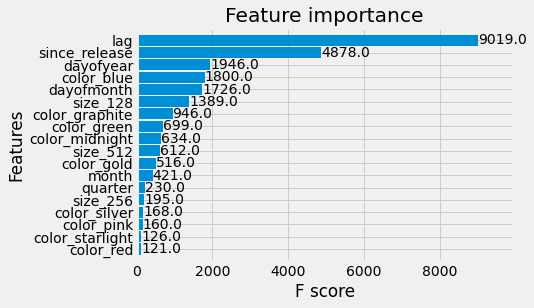

In [162]:
_ = plot_importance(mod, height=0.9)